# Linear equation systems

**Table of contents**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
- 2. [Matrix equations](#toc2_)    
- 3. [Various other matrix operations](#toc3_)    
- 4. [Gauss-Jordan elimination (+)](#toc4_)    
- 5. [Details on LU factorization (+)](#toc5_)    
- 6. [Iterative Gauss-Seidel (+)](#toc6_)    
- 7. [Sparse matrices (+)](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

You will learn about working with matrices and linear algebra (**scipy.linalg**), including solving systems of linear equations.

**scipy.linalg:** [overview](https://docs.scipy.org/doc/scipy/reference/linalg.html) + [tutorial](https://docs.scipy.org/doc/scipy/tutorial/linalg.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

import time
from scipy import linalg

# local module for linear algebra
%load_ext autoreload
%autoreload 2
import local_linalg

## 1. <a id='toc1_'></a>[Introduction](#toc0_)

A lot of economic models can be expressed as system of equations. Question is how to solve them?

As a very easy example, just think of the market equilibrium when you have a supply curve and a demand curve.

Consider a market, where suppliers have a **supply curve**
$$
q = 5 + \frac{1}{3}p
$$
and consumers have a **demand curve** 
$$
q = 10 - 2p
$$

This gives rise to a linear system of equations
$$
\begin{align}
q-\frac{1}{3}p &= 5 \\
q+2p &= 10 \\
\end{align}
$$

We can put this into matrix notation $Ax=b$ by
$$
\begin{bmatrix} 
1 & -1/3 \\
1 & 2 \\ 
\end{bmatrix} \cdot 
\begin{bmatrix} 
q \\ 
p \\ 
\end{bmatrix} = 
\begin{bmatrix} 
5 \\ 
10 \\
\end{bmatrix}
$$

**Solving** for the equilibrium $x = [q,p]$ means solving for $x$ in $Ax=b \Leftrightarrow x = A^{-1}b$.  

In [2]:
A = np.array([[1.0,-1.0/3.0],[1.0,2.0]])
b = np.array([5.0,10.0])

Ainv = linalg.inv(A)
sol = Ainv@b
print(sol)

[5.71428571 2.14285714]


**Task:** Find the equilibrium if the demand surve instead was $q = 20 - 2p$.

In [3]:
A = np.array([[1.0,-1.0/3.0],[1.0,2.0]])
b = np.array([5.0,20.0])

Ainv = linalg.inv(A)
sol = Ainv@b
print(sol)

[7.14285714 6.42857143]


## 2. <a id='toc2_'></a>[Matrix equations](#toc0_)

More generally, we consider **matrix equations** with $n$ equations and $n$ unknowns:

$$
\begin{aligned}
Ax = b \Leftrightarrow
\begin{bmatrix}a_{11} & a_{12} & \cdots & a_{1n}\\
a_{21} & a_{22} & \cdots & a_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix}\begin{bmatrix}x_{1}\\
x_{2}\\
\vdots\\
x_{n}
\end{bmatrix} & = \begin{bmatrix}b_{1}\\
b_{2}\\
\vdots\\
b_{n}
\end{bmatrix}
\end{aligned}
$$

where $A$ is a square parameter matrix, $b$ is a parameter vector, and $x$ is the vector of unknowns.

A specific **example** could be:

$$ 
\begin{aligned}
Ax = b \Leftrightarrow
\begin{bmatrix} 
3 & 2 & 0 \\ 
1 & -1 & 0 \\
0 & 5 & 1
\end{bmatrix} 
\begin{bmatrix} 
x_1 \\ 
x_2 \\
x_3
\end{bmatrix} \,=\,
\begin{bmatrix} 
2 \\ 
4 \\
-1
\end{bmatrix} 
\end{aligned}
$$

**How to solve this?**

In [4]:
A = np.array([[3.0, 2.0, 0.0], [1.0, -1.0, 0], [0.0, 5.0, 1.0]])
b = np.array([2.0, 4.0, -1.0])

**Option 1:** Compute `.inv()` first and then solve.

In [5]:
x = linalg.inv(A)@b
print(x)
assert np.allclose(A@x,b)

[ 2. -2.  9.]


**Note:** Computing the inverse is normally not a good idea due to numerical stability.

**Option 2:** Use `.solve()` (scipy chooses what happens).

In [6]:
x = linalg.solve(A,b)
print(x)
assert np.allclose(A@x,b)

[ 2. -2.  9.]


**Example of better numerical properties:** $Hz=d$

In [7]:
H = np.array([[1000, 999,998],[999, 998,997],[998,997,999]]) # "bad" matrix
z = np.array([100,1000,10000]) # known answer
d = H@z # implied right-hand side

print('error with linalg.inv:')
print(np.linalg.inv(H)@d-z)

print('')

print('error with linalg.solve:')
print(np.linalg.solve(H,d)-z)


error with linalg.inv:
[ 2.17789784e-06 -4.10713255e-07  9.31322575e-10]

error with linalg.solve:
[-4.94648475e-07  4.94765118e-07  3.78349796e-10]


**Option 3:** Compute LU decomposition and then solve.

In [8]:
LU,piv = linalg.lu_factor(A) # so-called LU decomposition (factorization)
x = linalg.lu_solve((LU,piv),b)
print(x)
assert np.allclose(A@x,b)

[ 2. -2.  9.]


**Note:** `linalg.lu_solve()` is the best choice when solving for multipe $b$'s for a fixed $A$ because the LU decomposition only needs to be done once.

**Timings:**

In [9]:
%timeit linalg.solve(A,b)
%timeit linalg.lu_factor(A)
%timeit linalg.lu_solve((LU,piv),b)

67.9 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
14.9 µs ± 1.36 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.8 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


**Task:** Complete the code below using first `linalg.solve` and then `linalg.lu_solve`.

In [17]:
cs = [np.random.uniform(size=(3,)) for _ in range(10)]

try:
    for c in cs:
        x = linalg.solve(A,c)
        assert np.allclose(A@x,c), 'solution not correct'

    print('sucessfull')

except Exception as e:

    print(f'not sucessfull, {e}')

    

sucessfull


In [18]:
cs = [np.random.uniform(size=(3,)) for _ in range(10)]

try:
    LU,piv = linalg.lu_factor(A) # so-called LU decomposition (factorization)
    for c in cs:
        x = linalg.lu_solve((LU,piv),c)
        assert np.allclose(A@x,c), 'solution not correct'

    print('sucessfull')

except Exception as e:

    print(f'not sucessfull, {e}')

sucessfull


## 3. <a id='toc3_'></a>[Various other matrix operations](#toc0_)

In [19]:
A.T # transpose

array([[ 3.,  1.,  0.],
       [ 2., -1.,  5.],
       [ 0.,  0.,  1.]])

In [12]:
np.diag(A) # diagonal

array([ 3., -1.,  1.])

In [13]:
B = A.copy()
np.fill_diagonal(B,0) # fill diagonal with zeros
print(B)

[[0. 2. 0.]
 [1. 0. 0.]
 [0. 5. 0.]]


In [14]:
np.eye(3) # identity matrix

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [15]:
np.tril(A) # lower triangular matrix

array([[ 3.,  0.,  0.],
       [ 1., -1.,  0.],
       [ 0.,  5.,  1.]])

In [16]:
np.triu(A) # upper triangular matrix

array([[ 3.,  2.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])

In [17]:
linalg.eigvals(A) # eigen values

array([ 1.        +0.j, -1.44948974+0.j,  3.44948974+0.j])

... and many more.

## 4. <a id='toc4_'></a>[Gauss-Jordan elimination (+)](#toc0_)

**How could the code for linalg.solve and linalg.inv be written?**

Consider the column stacked matrix:

$$
X=[A\,|\,b]=\begin{bmatrix}a_{11} & a_{12} & \cdots & a_{1n} & b_{1}\\
a_{21} & a_{22} & \cdots & a_{2n} & b_{2}\\
\vdots & \vdots & \ddots & \vdots & \vdots\\
a_{n1} & a_{n2} & \cdots & a_{nn} & b_{n}
\end{bmatrix}
$$

Find the **row reduced echelon form** by performing row operations, i.e.

1. Multiply row with constant
2. Swap rows
3. Add one row to another row,

until the $A$ part of the matrix is the identity matrix.

**Manually:**

Stack:

In [20]:
X = np.column_stack((A,b))
print(X)

[[ 3.  2.  0.  2.]
 [ 1. -1.  0.  4.]
 [ 0.  5.  1. -1.]]


Find row reduced echelon form:

In [21]:
X[0,:] += 2*X[1,:]
X[0,:] /= 5.0
X[1,:] -= X[0,:]
X[1,:] *= -1
X[2,:] -= 5*X[1,:]

print(X)

[[ 1.  0.  0.  2.]
 [-0.  1. -0. -2.]
 [ 0.  0.  1.  9.]]


Solution in last column:

In [22]:
print(X[:,-1])
assert np.allclose(A@X[:,-1],b)

[ 2. -2.  9.]


**General function:**

In [23]:
Y = np.column_stack((A,b))
local_linalg.gauss_jordan(Y)
print('solution',Y[:,-1])

solution [ 2. -2.  9.]


which can also be used to find the inverse if we stack with the identity matrix instead,

In [28]:
# a. construct stacked matrix
Z = np.hstack((A,np.eye(3)))
print('stacked:\n',Z)

# b. apply gauss jordan elimination
local_linalg.gauss_jordan(Z)

# b. find inverse
inv_Z = Z[::] # last 3 columns of Z in row reduced echelon form
print('inverse:\n',inv_Z)

assert np.allclose(Z[:,3:]@A,np.eye(3))

stacked:
 [[ 3.  2.  0.  1.  0.  0.]
 [ 1. -1.  0.  0.  1.  0.]
 [ 0.  5.  1.  0.  0.  1.]]
inverse:
 [[ 1.   0.   0.   0.2  0.4  0. ]
 [ 0.   1.   0.   0.2 -0.6  0. ]
 [ 0.   0.   1.  -1.   3.   1. ]]


## 5. <a id='toc5_'></a>[Details on LU factorization (+)](#toc0_)

**What is a LU decomposition more precisely?**


When $A$ is *regular* (invertible), we can decompose it into a *lower unit triangular matrix*, $L$, and an *upper triangular matrix*, $U$:

$$
A= \begin{bmatrix}a_{11} & a_{12} & \cdots & a_{1n}\\
a_{21} & a_{22} & \cdots & a_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix} 
= L\cdot U = \begin{bmatrix}1 & 0 & \cdots & 0\\
l_{21} & 1 & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
l_{n1} & l_{n2} & \cdots & 1
\end{bmatrix}\cdot\begin{bmatrix}u_{11} & u_{12} & \cdots & u_{1n}\\
0 & u_{22} & \cdots & u_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & u_{nn}
\end{bmatrix}
$$

By starting with the top row of the $upper$ part and the first $column$ of the lower part, we can work our way through using the definition of a matrix product. Note that we actively use the fact that there are 1s on the diagonal of the lower matrix.

$$
\begin{aligned}
\textrm{if    }&\\
 &i = 1: \:\: u_{1j} = a_{1j} \:\:\:\: (\textit{top row is identical to that of A})\\
 &j = 1: \:\: l_{i1} = \frac{a_{i1}}{u_{11}} \\
\textrm{else}&\\
&u_{ij} = a_{ij} - \sum_{k=1}^{i-1} u_{kj} l_{ik} \\
%\textrm{else  }\:\:
&l_{ij} = \frac{1}{u_{jj}} \big( a_{ij} - \sum_{k=1}^{j-1} u_{kj} l_{ik} \big)
\end{aligned}
$$

You can therefore get $L$ and $U$ by following steps:
* First obtain row 1 of $U$. It's equal to row 1 of $A$. 
* Then get column 1 of $L$.
* This will allow you to get $u_{2,2}$
* Based on $u_{1,2},u_{2,1},u_{2,2},l_{1,1},l_{1,2}$ you can get $l_{3,2}$.
* Keep working out subsequent $u_{ij}$ and $l_{ij}$ based on above formulas. 

The factorization implies that the equation system can be written

$$ 
Ax = L(Ux) = b 
$$


**Algorithm:** `lu_solve()`  
3 steps and you are done:
1. Perform LU decomposition (factorization)
2. Solve for $y$ in $Ly = b$ (using *forward substitution* - recursive system from top to bottom)

    $y_1 = b_1,\,\, y_2 = b_2-l_{21}y_1,\,\, \dots$

3. Solve for $x$ in $Ux = y$ (using  *backward substitution* - recursive system from bottom to top)

    $x_n = y_n/u_{nn},\,\, x_{n-1} = (y_{n-1}-u_{n-1n}x_n)/u_{n-1n-1},\dots$

In [23]:
L,U = local_linalg.lu_decomposition(A) # step 1
y = local_linalg.solve_with_forward_substitution(L,b) # step 2
x = local_linalg.solve_with_backward_substitution(U,y) # step 3
print('A:\n',A)
print('L:\n',L)
print('\nU:\n',U)
print('\nsolution:',x)
assert np.allclose(A@x,b)

A:
 [[ 3.  2.  0.]
 [ 1. -1.  0.]
 [ 0.  5.  1.]]
L:
 [[ 1.          0.          0.        ]
 [ 0.33333333  1.          0.        ]
 [ 0.         -3.          1.        ]]

U:
 [[ 3.          2.          0.        ]
 [ 0.         -1.66666667  0.        ]
 [ 0.          0.          1.        ]]

solution: [ 2. -2.  9.]


**Relation to scipy:**

1. Scipy use pivoting to improve numerical stability.
2. Scipy is implemented much much better than here.

## 6. <a id='toc6_'></a>[Iterative Gauss-Seidel (+)](#toc0_)

**An approximate method for solving linear matrix equation systems.**

We can always decompose $A$ into *additive* lower and upper triangular matrices,

$$
A=L+U=\begin{bmatrix}a_{11} & 0 & \cdots & 0\\
a_{21} & a_{22} & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix}+\begin{bmatrix}0 & a_{12} & \cdots & a_{1n}\\
0 & 0 & \cdots & a_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & 0
\end{bmatrix}
$$

such that

$$
Ax=b\Leftrightarrow \underbrace{Lx}_{\text{LHS}}=\underbrace{b-Ux}_{\text{RHS}}
$$

The idea and beauty of the algorithm is that we go from an identity, $Ax=b$, to an iteration on $x$. This is because the $x$ on the LHS above is **not** the same $x$ as on the RHS. It is an update! And if we keep making updates, we will eventually get the solution. See how below.   

**Algorithm:** `gauss_seidel()`

1. Choose tolerance $\epsilon > 0$ and set $n=1$. Define the initial **guess** on $x$ denoted $x_0$.
2. From $A$, get $L$ and $U$ as the lower and upper part.
2. Set $\tilde{x}= x_0$
2. Given $\tilde{x}$, calculate $y_n = (b-U\tilde{x})$.
2. Given $y_n$ solve for $x_{n}$ in the equation $Lx_{n} = y_n$.
3. If $|x_{n}-\tilde{x}|_{\infty} < \epsilon$ stop.   
   Else, set $\tilde{x} = x_{n}$ and $n=n+1$ and return to step 4.

Why is this smart? Because it relies on solving a system of equations, $Lx_n=y_n$, where $L$ is **lower triangular**. It is much easier to solve a system of a lower triangular matrix, because we can use **forward substitution** (as above).  

**Apply Gauss-Seidel:**

In [29]:
x0 = np.array([1,1,1])
x =  local_linalg.gauss_seidel(A,b,x0)
print('solution',x)
assert np.allclose(A@x,b)

solution [ 2. -2.  9.]


> **Note:** Convergence is not ensured unless the matrix is *diagonally dominant* or *symmetric* and *positive definite*.

In [30]:
x =  local_linalg.gauss_seidel(A,b,x0,do_print=True)

   [1 1 1]
  0: [  0.00000000  -4.00000000  19.00000000]
  1: [  3.33333333  -0.66666667   2.33333333]
  2: [  1.11111111  -2.88888889  13.44444444]
  3: [  2.59259259  -1.40740741   6.03703704]
  4: [  1.60493827  -2.39506173  10.97530864]
  5: [  2.26337449  -1.73662551   7.68312757]
  6: [  1.82441701  -2.17558299   9.87791495]
  7: [  2.11705533  -1.88294467   8.41472337]
  8: [  1.92196312  -2.07803688   9.39018442]
  9: [  2.05202459  -1.94797541   8.73987705]
 10: [  1.96531694  -2.03468306   9.17341530]
 11: [  2.02312204  -1.97687796   8.88438980]
 12: [  1.98458531  -2.01541469   9.07707347]
 13: [  2.01027646  -1.98972354   8.94861769]
 14: [  1.99314903  -2.00685097   9.03425487]
 15: [  2.00456732  -1.99543268   8.97716342]
 16: [  1.99695512  -2.00304488   9.01522439]
 17: [  2.00202992  -1.99797008   8.98985041]
 18: [  1.99864672  -2.00135328   9.00676639]
 19: [  2.00090219  -1.99909781   8.99548907]
 20: [  1.99939854  -2.00060146   9.00300729]
 21: [  2.00040097  -1.

## 7. <a id='toc7_'></a>[Sparse matrices (+)](#toc0_)

You may sometimes deal with a matrix that is really large, but **most** of the entries are 0s. Not uncommon in econometrics or large systems of equations.  

In that case, you can save a lot of memory by removing all the 0s from memory and let Python only worry about the non-zero numbers. That of course requires a whole new set of routines for matrix operations, since the elements are no longer contiguous.    

It can be worth it if about 70% of your matrix is just 0s. 

**scipy.sparse.linalg** allows you to solve systems of equations with sparse matrices. 

**documentation:** [basics](https://docs.scipy.org/doc/scipy/reference/sparse.html) + [linear algebra](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html#module-scipy.sparse.linalg)

**create a sparse matrix**, where most elements are on the diagonal:

In [32]:
from scipy import sparse
import scipy.sparse.linalg

# construct some sparse matrix
S = sparse.lil_matrix((1000, 1000)) # 1000x1000 matrix with zeroes
S.setdiag(np.random.rand(1000)) # some values on the diagonal
S[200, :100] = np.random.rand(100) # some values in a row
S[200:210, 100:200] = S[200, :100] # and the same value in some other rows

# other matrix formats
S_csr = S.tocsr()
S_csc = S.tocsc()

Create a plot of the values in the matrix:

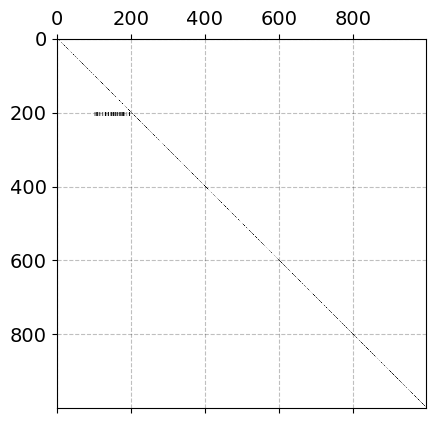

In [33]:
S_np = S.toarray() # conversion to numpy
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.matshow(S_np,cmap=plt.cm.binary);

**Solve it in four different ways:**

1. Like it was not sparse
2. Using the sparsity
3. Using the sparsity + explicit factorization
4. Iterative solver (similar to Gauss-Seidel)

In [37]:
# just use some random numbers for right hand side of equation
k = np.random.rand(1000) 

# a. solve 
t0 = time.time()
x = linalg.solve(S_np,k)
print(f'{"solve":12s}: {time.time()-t0:.5f} secs')

# b. solve using sparse matrix algebra in spsolve
t0 = time.time()
x_alt = sparse.linalg.spsolve(S_csr, k)
print(f'{"spsolve":12s}: {time.time()-t0:.5f} secs')
assert np.allclose(x,x_alt)
      
# c. solve with explicit factorization
t0 = time.time()
S_solver = sparse.linalg.factorized(S_csc)
x_alt = S_solver(k)
print(f'{"factorized":12s}: {time.time()-t0:.5f} secs')
assert np.allclose(x,x_alt)
      
# d. solve with iterative solver (bicgstab)
t0 = time.time()
x_alt,_info = sparse.linalg.bicgstab(S,k,x0=1.001*x,tol=10**(-8))
print(f'{"bicgstab":12s}: {time.time()-t0:.5f} secs')
assert np.allclose(x,x_alt),x-x_alt

solve       : 0.04665 secs
spsolve     : 0.00258 secs
factorized  : 0.00000 secs
bicgstab    : 0.04989 secs


**Take-aways:** 

1. Using the sparsity can be very important.
2. Iterative solvers can be very very slow.